In [1]:
import numpy as np
import pandas as pd
import scipy.stats as S
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import Tuple, List

# 2.1

Given simple quadratic function $g(w) = w^Tw$ where w is vector of N dimension

Demonstrate curse of dimensionality by sampling P times, where P = 100 from N = 1 to N = 100.

First sample it such that the distance from each point is uniform (we need scipy dev for this since llyod hypercube optimization is only available in dev currently as of 16 Oct). Yes Sampling on hypercube with uniform space outcome is a different beast on its own and I'm not willing to implement it currently (maybe in future). Current implementation is rand uniform but I believe it's not actually so different from sampling in random manner.

Second sample it in random manner.


In [3]:
def g(w: np.array) -> int:
    """
    quadratic equation w**2 centered at 0
    :param w:
    :return:
    """
    r = np.matmul(np.transpose(w), w)
    return r

def simulate(N, P, lb=-1, ub=1) -> List[Tuple[int, int, int]]:
    # range -1, 1 for each dim
    result = []
    dims = []
    for n in range(1, N+1):
        lowest = min([g(np.random.uniform(lb, ub, n)) for _ in range(P)])
        result.append(lowest)
        dims.append(n)
    return list(zip(result, dims, [P]*N))

def simulate2(N, P, lb=-1, ub=1) -> List[Tuple[int, int, int]]:
    # range -1, 1 for each dim
    result = []
    dims = []
    for n in range(1, N+1):
        lowest = min([g(2*np.random.rand(n)-1) for _ in range(P)])
        result.append(lowest)
        dims.append(n)
    return list(zip(result, dims, [P]*N))

/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_68600/3192662244.py:17: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(df1, x='dims', y='result', hue='P', palette=sns.color_palette("bright"), ax=axes[0])
/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_68600/3192662244.py:19: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.lineplot(df2, x='dims', y='result', hue='P', palette=sns.color_palette("bright"), ax=axes[1])


Text(0.5, 1.0, '1-100 Dimensions plot with various samples')

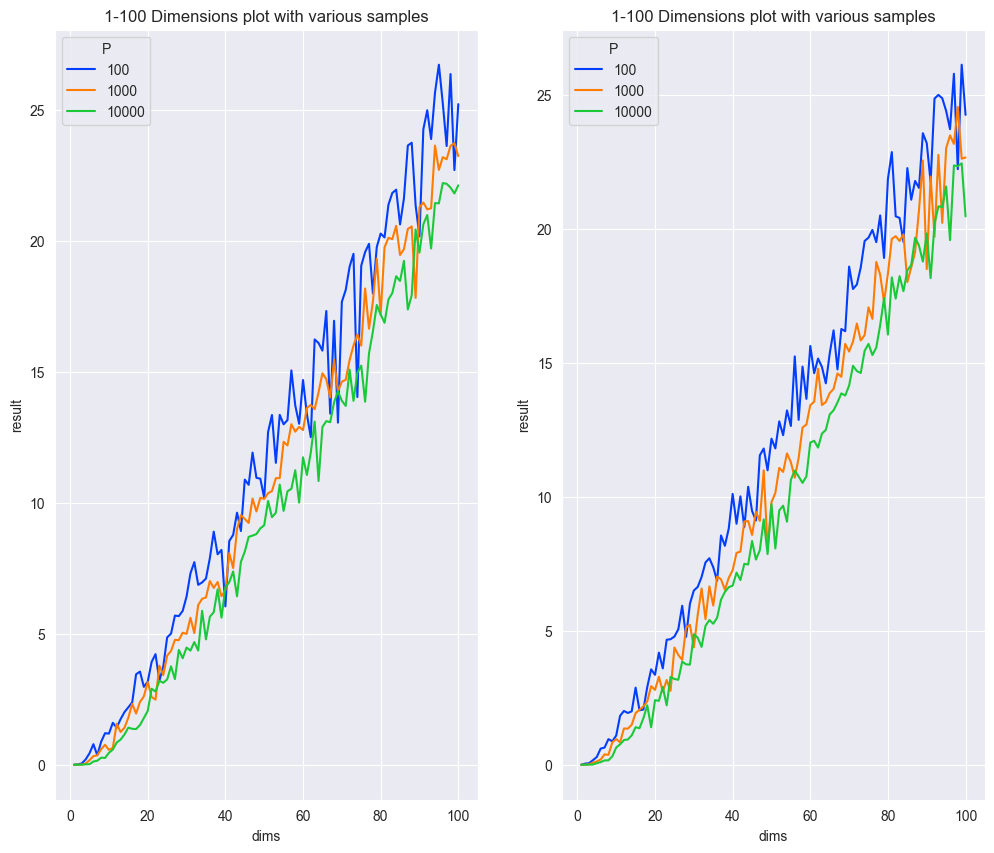

In [4]:
"""
trend seen uniform:
as p gets higher, the resulting minimum value attained is lower.

unsure part: not sure if uniform vs random is uniform sample or do i have to do
hypercube + llyod optimization sampling or just do a formal set
"""
set_1 = []
for p in range(2,5):
    set_1.extend(simulate(100, 10**p))
df1 = pd.DataFrame(set_1, columns=['result', 'dims', 'P'])
set_2 = []
for p in range(2,5):
    set_2.extend(simulate(100, 10**p))
df2 = pd.DataFrame(set_2, columns=['result', 'dims', 'P'])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))
sns.lineplot(df1, x='dims', y='result', hue='P', palette=sns.color_palette("bright"), ax=axes[0])
axes[0].set_title('1-100 Dimensions plot with various samples')
sns.lineplot(df2, x='dims', y='result', hue='P', palette=sns.color_palette("bright"), ax=axes[1])
axes[1].set_title('1-100 Dimensions plot with various samples')

# 2.2

implementation of random search algorithm
1. take in a vector
2. create set of direction vectors according to P, direction vectors should have a length of 1
3. walk in the best direction
4. repeat the process K times


Basic implementation done

TODO: change this to class type so that it's easy to plot histories.


In [13]:
def g_w_single(w: np.array) -> int:
    """
    if shape more than 1 --> raise aerror for using this function
    :param w:
    :return:
    """
    if w.shape[0] > 1:
        raise Exception('g_w_single expect only w of single dimension')
    return np.sin(w[0]*3) + 0.3*w[0]**2

def create_direction_vector(dim: int, alpha: float = 0.1) -> np.array:
    """
    we first generate vector of dim size, then normalize to its unit norm
    :param dim:
    :return:
    """
    d = np.random.uniform(-1, 1, dim)
    d_norm = np.linalg.norm(d)
    if d_norm == 0:
        return d
    # norm2 = normalize(d[:, np.nedaxis], axis=1).ravel() # scipy way
    return d / d_norm * alpha


def create_directions(dim: int, P: int, alpha: float = 0.1) -> List[np.array]:
    return [create_direction_vector(dim, alpha=alpha) for _ in range(P)]

from collections.abc import Callable
from typing import Optional
def random_search(w: Optional[np.array], dim: int, K: int, P: int, op_function: Callable,
                  alpha: float = 0.1) -> Tuple[int, np.array]:
    """

    :param w:
    :param dim:
    :param K:
    :param P:
    :param op_function:
    :param alpha:
    :return:
    """
    if w is None:
        w = np.random.rand(dim)
    cost = float('inf')
    for _ in range(K):
        directs = create_directions(dim, P, alpha=alpha)
        neww = [op_function(w + d) for d in directs]
        nindex = np.argmin(neww)
        if neww[nindex] < cost:
            cost = neww[nindex]
            w = w + directs[nindex]
    return cost, w

In [14]:
# close enough to what we got in the book
random_search(w = np.array([4.5]), dim=1, K=10, P=2, op_function=g_w_single)

(3.4126714743353297, array([3.8]))

In [15]:
# close enough to the book
random_search(w = np.array([-1.5]), dim=1, K=10, P=2, op_function=g_w_single)

(-0.7162093666488742, array([-0.7]))